### Importering av bibliotek

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spectral
from PIL import Image

### Funksjoner

In [93]:
def calibrate_wavelengths(ImageWidth, Spectral_lines, Pixel_positions, Degree, Output_file):
    """
    Calibrate pixel positions to wavelengths.

    Parameters:
    - ImageWidth: int, number of pixels.
    - Spectral_lines: list of float, spectral lines or known wavelengths in nm.
    - Pixel_positions: list of int, pixel positions corresponding to the known spectral lines.
    - Degree: int, degree of the polynomial fit (1 for linear).
    - Output_file: str, path to the output CSV file.

    Returns:
    - df: pandas DataFrame, containing pixel positions and calibrated wavelengths.
    """
    if len(Spectral_lines) != len(Pixel_positions):
        raise ValueError("The number of wavelengths must match the number of pixel positions.")
    if len(Spectral_lines) < 2:
        raise ValueError("At least two wavelengths and pixel positions are required for calibration.")

    # Fit a polynomial function to the known wavelengths at the pixel positions
    wavelength_fit = np.polyfit(Pixel_positions, Spectral_lines, Degree)
    wavelength_calibration = np.poly1d(wavelength_fit)

    # Calibrate the pixel positions to wavelengths
    calibrated_wavelengths = wavelength_calibration(np.arange(ImageWidth))

    # Create a DataFrame
    df = pd.DataFrame({
        'Pixel Position': np.arange(len(calibrated_wavelengths)),
        'Calibrated Wavelength (nm)': calibrated_wavelengths
    })

    # Save the DataFrame to a CSV file
    df.to_csv(Output_file, index=False)
    return df

def expected_irradiance(B_0):
    R = 0.92
    r_0 = 0.5 # from source to lambertian surface
    alpha = 0 # angle between source and normal to lambert
    p = 0.98 # diffusion coefficient of lambertian surface
    B_expected = B_0*(r_0/R)**2*p*np.cos(alpha) # photons/cm^2/s/Å

    return B_expected

def read_bip_file(file_path, width, height):
    with open(file_path, 'rb') as file:
        data = file.read()
    
    # Konverter binærdata til numpy array med 8-bit unsigned integers
    raw_data = np.frombuffer(data, dtype=np.uint8)
    
    # Kombiner 8-bit verdier til 16-bit verdier
    total_pixels = width * height
    pixel_data = np.zeros(total_pixels, dtype=np.uint16)
    
    for i in range(total_pixels):
        byte_index = i * 2
        pixel_data[i] = (raw_data[byte_index] << 8) | raw_data[byte_index + 1]
    
    # Reshape array til 2D bilde
    image = pixel_data.reshape((height, width))
    return image

### Bølgelengde Kalibrering

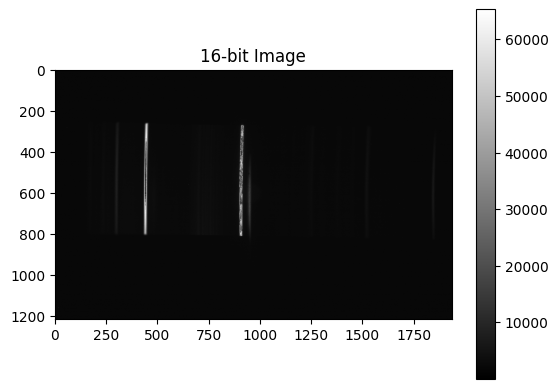

In [99]:


file_path = 'Data/H/1727181196.353_00000_e049.9971_g000_1936x1216.bip'
width = 1936
height = 1216

image = read_bip_file(file_path, width, height)

# Visualiser bildet
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('16-bit Image')
plt.show()


In [95]:
ImageWidth = 1024
Spectral_lines = [656.3, 486.1, 546.1, 502.5] # Hydrogen (H), Helium (He), Mercury (Hg)
pixel_positions = [100, 300, 500, 700]
degree = 2
output_file = 'Data/calibrated_wavelengths.csv'

df = calibrate_wavelengths(ImageWidth, Spectral_lines, pixel_positions, degree, output_file)
wavelengths = np.loadtxt(output_file, delimiter=',', skiprows=1, usecols=1)

#print(wavelengths)
#print(df.to_string(index=False))

### Intensitet Kalibrering

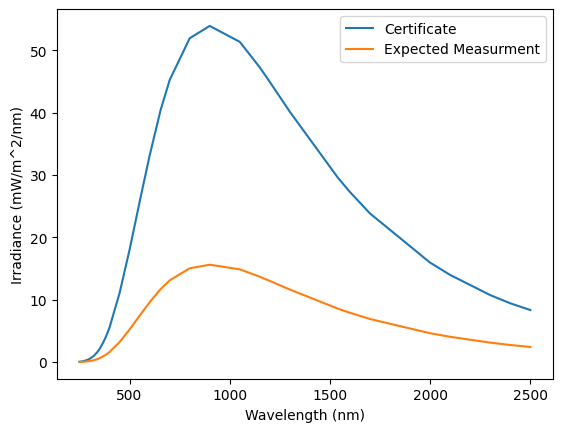

In [96]:
#Measured data
#B_measured = np.loadtxt('Data/measured.csv', delimiter=',', skiprows=1, usecols=1) # photons/cm^2/s/Å
#B_0 = np.loadtxt('Data/B0.csv', delimiter=',', skiprows=1, usecols=0) # photons/cm^2/s/Å

#Certificate data
W_L = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=0) # Wavelengths in nm
B_0 = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=1) # Irradiance in mW/m^2/nm
sigma = np.loadtxt('Data/calibrationCertificate200W.txt', usecols=2) # Uncertainty in %


ImageHeight = 256

B_expected = expected_irradiance(B_0)

# plot B_0
plt.figure()
plt.plot(W_L,B_0, label='Certificate')
plt.plot(W_L,B_expected, label='Expected Measurment')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (mW/m^2/nm)')
plt.legend()
plt.show()